In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4

In [3]:
data = xr.open_dataset('./cmems_obs-oc_atl_bgc-transp_my_l3-multi-1km_P1D.nc')

data_SPM_nonan=np.where(np.isnan(data.SPM.values), 0., data.SPM.values)
print(f'data.SPM.values before log10, min(data.SPM.values) {np.min(data_SPM_nonan)} and max(data.SPM.values) {np.max(data_SPM_nonan)}' )

print('np.unique(data_SPM_nonan) before log 10', np.unique(data_SPM_nonan))
data.SPM.values = np.log10(data.SPM.values)

data_SPM_nonan=np.where(np.isnan(data.SPM.values), 0., data.SPM.values)
print(f'data.SPM.values after log10, min(data.SPM.values) {np.min(data_SPM_nonan)} and max(data.SPM.values) {np.max(data_SPM_nonan)}' )

print(data)
data.to_netcdf('GT_2015to2018_log10.nc')



data.SPM.values before log10, min(data.SPM.values) 0.0 and max(data.SPM.values) 100.00001525878906
np.unique(data_SPM_nonan) before log 10 [  0.           0.10176346   0.10176346 ... 100.         100.00001
 100.000015  ]
data.SPM.values after log10, min(data.SPM.values) -0.9924081563949585 and max(data.SPM.values) 2.0
<xarray.Dataset>
Dimensions:          (time: 1461, lat: 240, lon: 300)
Coordinates:
  * lon              (lon) float32 4.443 4.453 4.464 4.474 ... 7.536 7.547 7.557
  * time             (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2018-12-31
  * lat              (lat) float32 54.99 54.98 54.97 54.96 ... 52.53 52.52 52.51
Data variables:
    SPM              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    SPM_uncertainty  (time, lat, lon) float32 ...
Attributes: (12/92)
    FROM_ORIGINAL_FILE__lon_step:                     0.010416667
    keywords:                                         EARTH SCIENCE > OCEANS ...
    cmems_product_id:                      

In [ ]:
# import xarray as xr

# # Load the satellite images from a NetCDF file
# ds = xr.open_dataset('GT_2015to2018_log10.nc')

# # Assuming your images are stored in a variable named 'image_variable'
# # and the dimensions are 'lat' and 'lon'
# cropped_ds = ds.isel(lat=slice(0, 240), lon=slice(20, 260))

# # Save the cropped images to a new NetCDF file
# cropped_ds.to_netcdf('GT_2015to2018_log10_crop240.nc')


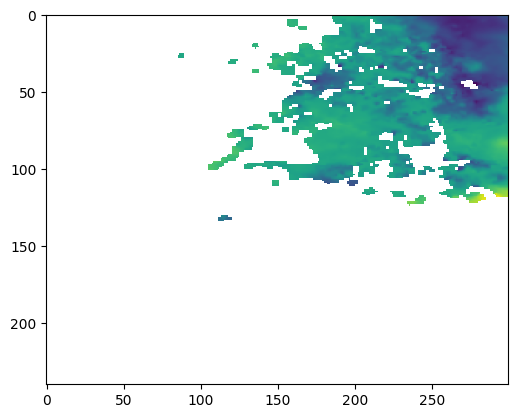

In [21]:
img=data.SPM[250,:,:]
plt.imshow(img)


In [12]:
########################
##### land mask ########
########################
mask = np.where(np.isnan(data.SPM.values), 0., 1.)
print('mask.shape',mask.shape)
nt = len(data.time)
print('nt: ', nt)
#print('mask: ', mask)
land_mask = np.float64(np.sum(mask==0,0)==nt)#axis=0 of the numpy.sum, land_mask shape (78,289) contains 0 and 1, 1 only at the place when all time-series x is NOT nan at that pixel
print('land_mask.shape',land_mask.shape)
land_mask[np.where(land_mask==0)] = np.nan
land_mask = xr.DataArray(land_mask,name="mask",coords=[data.lat,data.lon],dims=['lat','lon'])
print('land_mask after format as Xarray: ', land_mask)

#this 2 below is just to save the file containing land_mask
land_mask_file = 'land_mask.nc'
land_mask.to_netcdf(land_mask_file)

mask.shape (1461, 240, 300)
nt:  1461
land_mask.shape (240, 300)
land_mask after format as Xarray:  <xarray.DataArray 'mask' (lat: 240, lon: 300)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
  * lat      (lat) float32 54.99 54.98 54.97 54.96 ... 52.54 52.53 52.52 52.51
  * lon      (lon) float32 4.443 4.453 4.464 4.474 ... 7.526 7.536 7.547 7.557


In [13]:
land_mask.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])

In [14]:
##########################
#### Patch (50%) Obs. ####
##########################


# ~ lat_min = 52.5
# land_mask = land_mask.values#note that land_mask contains only 0 and 1

lon = data.lon
lat = data.lat

n_land_pix = np.nansum(land_mask)# sum of array elements over a given axis treating Not a Numbers (NaNs) as zero.==> number of 1-pixels
n_sea_pix = land_mask.size-n_land_pix# numbe of 0-pixels

np.random.seed(10)
for t in range(data.time.size):
    mask_patch = np.where(np.isnan(data.SPM[t].values),np.nan,1)#mask_patch contains only nan and 1, nan at places that SPM values is nan, and 1 otherwise

    #p_mv is the ratio of nan-pixels to sea-pixels, so if it's bigger than 0.75, then we need to cover more sea-pixels with nan-pixels
    p_mv = 1-np.nansum(mask_patch)/n_sea_pix# "np.nansum(mask_patch)/n_sea_pix" Oh, is it a problem here? n_sea_pix is to count #nan in all series, and np.nansum(mask_patch) is to count #NOT nan in the current x_t
    if p_mv <= .75:#i.e, np.nansum(mask_patch)/n_sea_pix bigger than 0.25!! Otherwise, no need to do anything since it is already too small (smaller than 0.25) !!!
        obj_p_mv = 1-.5*(np.nansum(mask_patch)/n_sea_pix)
        while p_mv <= obj_p_mv:#this one is always true since p_mv is always smaller than obj_p_mv
            half_patch_height = np.random.randint(2,10)
            idx_lat = np.random.randint(0,lat.size)
            idx_lon = np.random.randint(0,lon.size)
            mask_patch[np.max([0,idx_lat-half_patch_height]):np.min([lat.size,idx_lat+half_patch_height+1]),np.max([0,idx_lon-half_patch_height]):np.min([lon.size,idx_lon+half_patch_height+1])] = np.nan
            p_mv = 1-np.nansum(mask_patch)/n_sea_pix
                
    new_var = data.SPM[t].values
    new_var[np.where(np.isnan(mask_patch))] = np.nan

    data.SPM[t].values = new_var


data.to_netcdf('Obs_patch_2015to2018.nc')